## Info
Setting up the model to receate the hydrosynamics of the Solitary Wave model from BarSed.

Author: WaveHello

Date: 07/15/2024

### Notes
ADV data and pressure data for the solitary wave cases aren't in the folders I downloaded. I'm not sure where that data is or if it was recorded.

In [2]:
# import default modules
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import scipy
import pandas as pd
from scipy import special

# Set global constants
PI = np.pi

# method to import xbtools with try routine
try:
    import xbTools
except ImportError:
    print('**no xbTools installation found in environment, adding parent path of notebook to see if it works')
    sys.path.append(r"C:\ERDC\xbeach-toolbox")

**no xbTools installation found in environment, adding parent path of notebook to see if it works


In [3]:
# Import the classes that represent the runs
# Add the library to the path
sys.path.append(r"C:\ERDC\BarSed")

# Import the library modules

from lib.data_classes.Run import Run

In [4]:
from xbTools.grid.creation import xgrid
from xbTools.xbeachtools import XBeachModelSetup
from xbTools.xbeachpost import XBeachModelAnalysis
from xbTools.general.executing_runs import generate_batch_script, run_batch_script


In [5]:
def mieras_theo_wave_maker_disp(period, time):
    r"""
    Calculates the theoretical displacement of the wave maker in the BarSed
    experiments

    Evaluates:
        erf( \frac{T}{5} t )
        
        which is equivalent to:
        \frac{2}{\sqrt{\pi} \int_{0}^{\frac{t T}{5}}} e^{- \tau^{2}} d \tau
    """

    end_val = period * time /5

    return special.erf( end_val )

def calc_theo_solitary_wave_maker(period, time, scaling = 2, shift = -0.08):
    """
    Calculates the theoretical displacement of the wave maker 
    for the solitary wave cases in the BarSed experiments on the OSU wave maker.

    The equation used here doens't match the one presented in the paper but,
    the results are good for this function. It matches the measured data very 
    well for all cases

    The eqn. used here is:
    WM_{disp} (t) = 2 * erf (\frac{t - T/2}{T /5}) - 0.08
    """

    # Split the time in half using the period
    split_time = time - period / 2

    # Scaled period - Not sure why 5 is used but it seems to work
    scaled_period = period / 5

    # Normalize the time using the scaled period
    scaled_time = split_time / scaled_period

    # Evaluate the error function, scale it and shift it
    return scaling * special.erf(scaled_time) + shift

### Set the information for the selected Run

In [6]:
# Import the raw bathymetry
# Set the important paths
barsed_data_path = r"D:\ERDC\BarSed"

# Set the information needed for specifying the run
# Run number
run_number = "082"

# Run id
run_id = f"RUN{run_number}"

# Mat file for the first run
run_name = r"{}.mat".format(run_id)


### Set data that isn't directly available in the inputs

In [7]:
# NOTE: This is the time entered into the error function. A solitary wave has an infinite period
wave_maker_period = 45 # This comes from RUN_Log


### Get the bathymetry for the model

In [8]:
# Name of the bathy data binary
bathy_file_name = r"bathy.mat"

# Path to where I'm storing the bathymetry data
bathy_file_path = os.path.join(barsed_data_path, bathy_file_name)

print(f"Bathy file path: {bathy_file_path}")

Bathy file path: D:\ERDC\BarSed\bathy.mat


### Get the path to the wave gauge data

In [9]:

# Name of the folder containing the wave data
WG_data_folder_name = r"WG" 

# Path to where I'm storing the bathymetry data
WG_data_path = os.path.join(barsed_data_path, WG_data_folder_name)

# Path to the selected wave gauge data
wave_data_path = os.path.join(WG_data_path, run_name)

print(f"Run{run_number} wave mat file path: {wave_data_path}")

Run082 wave mat file path: D:\ERDC\BarSed\WG\RUN082.mat


### Get the path to the adv data
The period of the wave maker is stored in this data. Not using it for anything else at the momement.

In [10]:
# Name of the folder containing the adv data
ADV_data_folder_name = r"ADV"

# Path to where the velocity data is being stored
ADV_data_path = os.path.join(barsed_data_path, ADV_data_folder_name)

# Path to the adv data for the selected run
ADV_file_path = os.path.join(ADV_data_path, run_name)

print(f"{ADV_data_folder_name} file path: {ADV_data_path}")
print("{} Data for mat file path: {}".format(ADV_data_folder_name, ADV_file_path))

ADV file path: D:\ERDC\BarSed\ADV
ADV Data for mat file path: D:\ERDC\BarSed\ADV\RUN082.mat


### Collect the bathymetry data

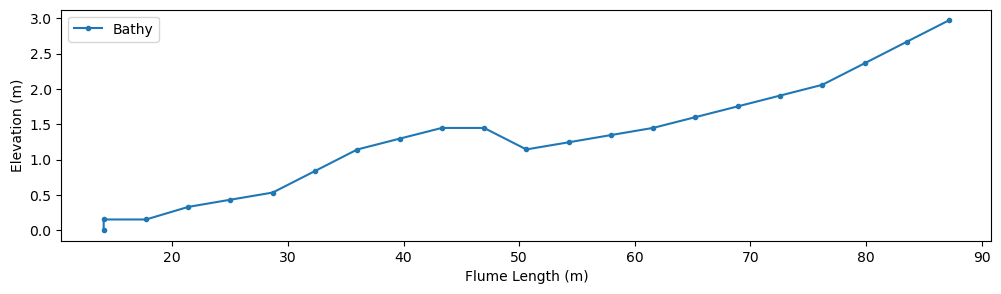

In [11]:
# Make a plot of the bathymetry to make sure the data is right
# Load the .mat file
bathy_dict = scipy.io.loadmat(bathy_file_path)

# Get the bathymetry data
bathy_df = pd.DataFrame(bathy_dict["bathy"], columns = ["x_loc", "z_loc"])

bathy_df.plot("x_loc", "z_loc", marker = ".", 
              figsize = (12, 3), label = "Bathy", 
              ylabel= "Elevation (m)", xlabel = "Flume Length (m)"
)

plt.legend()
plt.show()

### Construct the Run object
This object will help organize the data and help store the data

In [12]:
Run_082 = Run(id = run_id, wave_file_path=wave_data_path,
              ADV_file_path = ADV_file_path)

print(Run_082)


id: RUN082
Start Date: None
Wave Data File path: D:\ERDC\BarSed\WG\RUN082.mat
Num pressure gagues: None
Num advs: None


### Collect the wave gauge data

New Number of 17 wave gauges
Wave Maker information:
Number of times: 8362


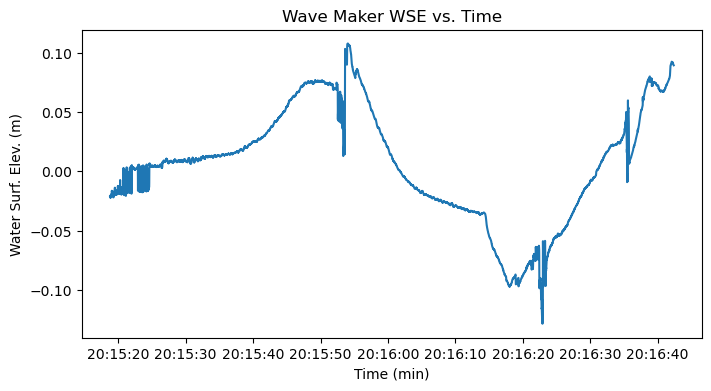

In [13]:
Run_082.load_wave_data()

print(Run_082.wave_maker)

Run_082.wave_maker.quick_wse_plot()

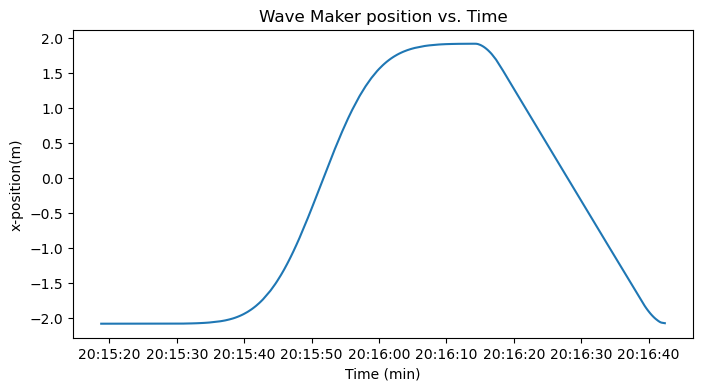

In [14]:
Run_082.wave_maker.quick_position_plot()

## Comparison of the theoretical wave maker displacement to the measured

### Notes:
* There's a 10 second offset from the start measured data to when the wave maker starts it's error function path
* The image (Range) of the error function is (-1, 1) therefore to get the measured data the theoretical value has to be scaled by 2.
* There's slight offset (about -0.08) that shifts the displacements down
* The function provided in Mieras et al. doesn't match the results. I think a mistake was made with how the time is tranformed before going into the eror function. 
  * The time needs to be shifted so that there are negative values so negative values of the error function can be produced. To do this the period is used to split the time into equal halves.


In [15]:
# Convert the wave maker date_time to time in seconds
first_time = Run_082.wave_maker.date_time[0]

seconds_from_first = np.array([(dt - first_time).total_seconds() for dt in Run_082.wave_maker.date_time])

time = np.linspace(0, wave_maker_period, 100)
theo_wave_disp = calc_theo_solitary_wave_maker(wave_maker_period, time)

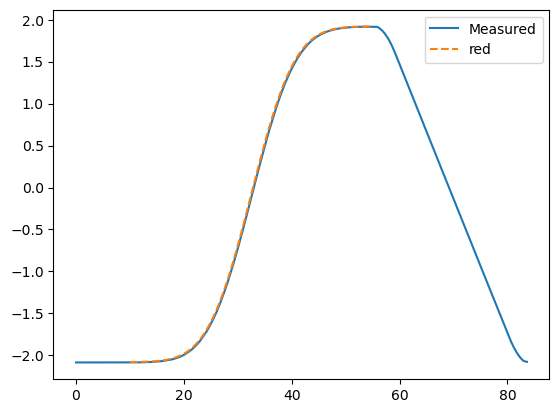

In [16]:
# Plot the theoretical and the measured wave maker displacement

fig, axs = plt.subplots(nrows = 1, ncols = 1)

axs = np.atleast_1d(axs)

shift = 10
wave_maker_loc = Run_082.wave_maker.position
axs[0].plot(seconds_from_first, wave_maker_loc, label = "Measured")
axs[0].plot(shift + time, theo_wave_disp , label = "red", linestyle = "dashed")

plt.legend()
plt.show()

## Generating the xBeach inputs

### Generating the Bathymetry

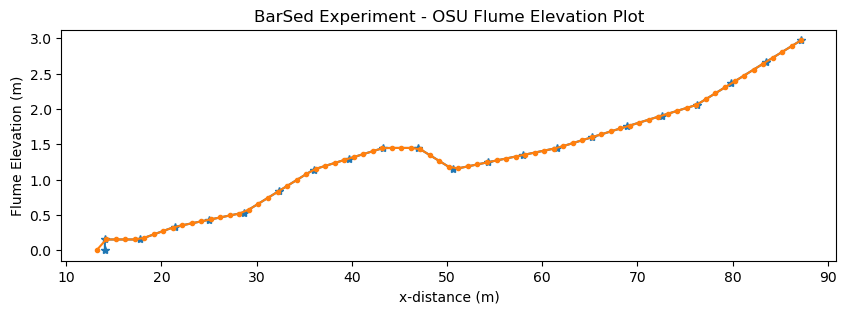

In [27]:
# Reinterpolate the raw bathymetry for the xBeach model

x = np.array(bathy_df["x_loc"])
z = np.array(bathy_df["z_loc"])

xgr, zgr = xgrid(x, z, dxmax = 0.1, dxmin = 1)


fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 3))

# Convert axs to an array so I can iterate over it if needed
axs = np.atleast_1d(axs)

axs[0].plot(x, z    , marker = "*", label = "Bathy")
axs[0].plot(xgr, zgr, marker = ".", label = "xgr")
# axs[0].axhline(y = 3.0)
axs[0].set_xlabel("x-distance (m)")
axs[0].set_ylabel("Flume Elevation (m)")

plt.title("BarSed Experiment - OSU Flume Elevation Plot")
plt.show()
#TODO: Need to look into what the proper procedure for 


### Generating the wave data

In [18]:
# Generate the wave boundary condition

# Calc the velocity of the



### Generating the computational params for the model

In [19]:
xb_setup = XBeachModelSetup('test')

xb_setup.set_grid(xgr, None, zgr, posdwn=-1, alfa=0)
xb_setup.set_nebed(np.ones_like(zgr))
xb_setup.set_friction(np.ones_like(zgr))

In [20]:
xb_setup.set_params({ "wbctype"     : "ts_1",
                     "wavemodel"    : "nonh",
                     "lateralwave"  : "neumann",
                     "nonh"         : 1,
                     "CFL"          : 0.5,
                     "zs0"          : 3,
                     "order"        : 1,
                     "ARC"          : 1,
                     "front"        : "nonh_1d", "back" : "abs_1d",
                     "left"         : "neumann", "right": "neumann",
                     "tstop"        : 10,

                     "tintm"        : 0.1,
                     "tintp"        : 0.1,
                     "tintg"        : 0.1,
                     'nglobalvar'   : ['zs', 'zb', 'H', "u", "v"],
})

The following params were not found in the JSON: 
{'nonh': 1}


In [21]:
# Set the params for the model

### Generating the model files

In [22]:
# Generate the model files
